In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objective: Build a PDF extractor to pull relevant details from CVs in PDF format, and match them against the job descriptions from the Hugging Face dataset.

# Required

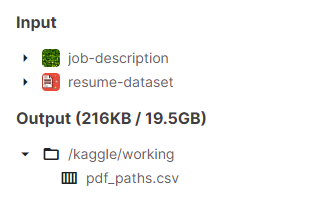

In [ ]:
!pip install transformers pdfplumber

# cleaner

In [2]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

# job description dataset

In [39]:
import pandas as pd
xdf=pd.read_csv('/kaggle/input/job-description/dataset.csv')
jobs = pd.DataFrame()
jobs['job'] = xdf.job_description.apply(lambda x: cleanResume(x))
jobs['title']=xdf.position_title

jobs['title']=jobs.title.apply(lambda x: cleanResume(x))
jobs['title']=jobs.title.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

aggregated_df = jobs.groupby('title').agg({
    'job': ', '.join  # Concatenate text values with a separator
}).reset_index()

jobs=aggregated_df
jobs[:3]

,title,job
0,Construction Project Managers Remote industr...,we have an immediate need for local or remote ...
1,hr Patient Advocate Part Time Position Mon Fri,job description the patient advocate will prov...
2,Business Development Project Manager,business development project manager remote un...


# test on small set

In [5]:
import pdfplumber
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load pretrained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to preprocess text and get embeddings
def preprocess_and_embed(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        output = model(**tokens)
    embeddings = output.last_hidden_state.mean(dim=1)  # Use the mean of token embeddings
    return embeddings

# List of job descriptions and CV details from PDFs
job_descriptions = jobs['job'][:5] # Replace with your list of job descriptions
job_titles= jobs['title'][:5]
cv_paths = ['/kaggle/input/resume-dataset/data/data/ACCOUNTANT/10554236.pdf',
            '/kaggle/input/resume-dataset/data/data/ENGINEERING/10030015.pdf'] # Replace with paths to your PDF CVs

# Process job descriptions
job_embeddings = [preprocess_and_embed(text) for text in job_descriptions]

# Process CVs from PDFs
cv_embeddings = []
for cv_path in cv_paths:
    with pdfplumber.open(cv_path) as pdf:
        cv_text = ''
        for page in pdf.pages:
            cv_text += page.extract_text()
    cv_embeddings.append(preprocess_and_embed(cv_text))

# Calculate Cosine Similarity
similarity_scores = []
for job_embedding in job_embeddings:
    scores = [cosine_similarity(job_embedding, cv_embedding)[0][0] for cv_embedding in cv_embeddings]
    similarity_scores.append(scores)

# Rank and display top 5 CVs per job description
for i, job_description in enumerate(job_descriptions):
    #print(f"Job Description {i + 1}: {job_description}")
    print(f"-> Job Profile {i}:{job_titles[i]} ")
    print("Top 5 CVs:")
    top_indices = sorted(range(len(similarity_scores[i])), key=lambda j: similarity_scores[i][j], reverse=True)[:5]
    for index in top_indices:
        print(f"CV {index + 1} - Similarity Score: {similarity_scores[i][index]}")
    print("=" * 50)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-> Job Profile 0:Sales Specialist 
Top 5 CVs:
CV 2 - Similarity Score: 0.8883664608001709
CV 1 - Similarity Score: 0.8865976929664612
-> Job Profile 1:Apple Solutions Consultant 
Top 5 CVs:
CV 2 - Similarity Score: 0.8272421956062317
CV 1 - Similarity Score: 0.8168385624885559
-> Job Profile 2:Licensing Coordinator - Consumer Products 
Top 5 CVs:
CV 2 - Similarity Score: 0.9043710231781006
CV 1 - Similarity Score: 0.8974179625511169
-> Job Profile 3:Web Designer 
Top 5 CVs:
CV 2 - Similarity Score: 0.8992958068847656
CV 1 - Similarity Score: 0.8825417757034302
-> Job Profile 4:Web Developer 
Top 5 CVs:
CV 2 - Similarity Score: 0.9015853404998779
CV 1 - Similarity Score: 0.8860648274421692


# generate pdf_path.cvs 

In [8]:
import os
import csv

# Directory path where PDF files are located (change this to your actual path)
directory_path = "/kaggle/input/resume-dataset/data/data"

# List to store the file paths
pdf_file_paths = []

# Walk through the directory and its subdirectories to find PDF files
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith(".pdf"):
            # Create the full file path
            file_path = os.path.join(root, file)
            pdf_file_paths.append(file_path)

# Define the CSV file name
csv_file_name = "pdf_paths.csv"

# Write the file paths to a CSV file
with open(csv_file_name, mode='w', newline='') as csv_file:
    fieldnames = ['File_Path']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for path in pdf_file_paths:
        writer.writerow({'File_Path': path})

print(f"CSV file '{csv_file_name}' created with {len(pdf_file_paths)} PDF file paths.")


CSV file 'pdf_paths.csv' created with 2484 PDF file paths.


# setup pdf path

In [69]:
PDF_LIMIT=50  # MUST BE LESS THEN OR EQUAL TO NO OF CV 
JOB_LIMIT=8    #MAX 2484

p=pd.read_csv(csv_file_name)
shuffled_pdf_path = p.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_pdf_path=shuffled_pdf_path[:PDF_LIMIT]
shuffled_pdf_path['cv']=shuffled_pdf_path.index+1
print('[info] no seleted pdf :',PDF_LIMIT)
print('[info] no job selected :',JOB_LIMIT)

[info] no seleted pdf : 50
[info] no job selected : 8


# Apply for all find top 5 CV for each category

In [65]:
import pdfplumber
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load pretrained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to preprocess text and get embeddings
def preprocess_and_embed(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        output = model(**tokens)
    embeddings = output.last_hidden_state.mean(dim=1)  # Use the mean of token embeddings
    return embeddings

# List of job descriptions and CV details from PDFs
job_descriptions = jobs['job'][:JOB_LIMIT] # Replace with your list of job descriptions
job_titles= jobs['title'][:JOB_LIMIT]
cv_paths = shuffled_pdf_path.File_Path # Replace with paths to your PDF CVs

# Process job descriptions
job_embeddings = [preprocess_and_embed(text) for text in job_descriptions]

# Process CVs from PDFs
cv_embeddings = []
for cv_path in cv_paths:
    with pdfplumber.open(cv_path) as pdf:
        cv_text = ''
        for page in pdf.pages:
            cv_text += page.extract_text()
    cv_embeddings.append(preprocess_and_embed(cv_text))

# Calculate Cosine Similarity
similarity_scores = []
for job_embedding in job_embeddings:
    scores = [cosine_similarity(job_embedding, cv_embedding)[0][0] for cv_embedding in cv_embeddings]
    similarity_scores.append(scores)
print('similarity_score: Generated')

similarity_score: Generated


# Result:

In [66]:
# Rank and display top 5 CVs per job description
for i, job_description in enumerate(job_descriptions):
    #print(f"Job Description {i + 1}: {job_description}")
    print(f"-> Job Profile {i}:{job_titles[i]} ")
    print("Top 5 CVs:")
    top_indices = sorted(range(len(similarity_scores[i])), key=lambda j: similarity_scores[i][j], reverse=True)[:5]
    for index in top_indices:
        print(f"CV {index + 1} - Similarity Score: {similarity_scores[i][index]}")
    print("=" * 50) 

-> Job Profile 0:  Construction Project Managers Remote industrial structures  
Top 5 CVs:
CV 42 - Similarity Score: 0.9498252272605896
CV 44 - Similarity Score: 0.9487069845199585
CV 38 - Similarity Score: 0.9471639394760132
CV 10 - Similarity Score: 0.945173978805542
CV 11 - Similarity Score: 0.9423037767410278
-> Job Profile 1:  hr Patient Advocate Part Time Position Mon Fri  
Top 5 CVs:
CV 14 - Similarity Score: 0.9251796007156372
CV 8 - Similarity Score: 0.9220617413520813
CV 39 - Similarity Score: 0.9128483533859253
CV 15 - Similarity Score: 0.9119607210159302
CV 9 - Similarity Score: 0.9119259119033813
-> Job Profile 2: Business Development Project Manager 
Top 5 CVs:
CV 34 - Similarity Score: 0.954449474811554
CV 42 - Similarity Score: 0.951411783695221
CV 29 - Similarity Score: 0.950805127620697
CV 24 - Similarity Score: 0.94867342710495
CV 49 - Similarity Score: 0.9477815628051758
-> Job Profile 3: Construction Project Manager 
Top 5 CVs:
CV 10 - Similarity Score: 0.946708142

# list of CV

In [73]:
shuffled_pdf_path[:5]

,File_Path,cv
0,/kaggle/input/resume-dataset/data/data/SALES/9...,1
1,/kaggle/input/resume-dataset/data/data/ACCOUNT...,2
2,/kaggle/input/resume-dataset/data/data/PUBLIC-...,3
3,/kaggle/input/resume-dataset/data/data/HEALTHC...,4
4,/kaggle/input/resume-dataset/data/data/BUSINES...,5
